In [1]:
!pip install -q langchain langchain-google-genai yfinance pandas numpy matplotlib plotly scipy newsapi-python python-dotenv beautifulsoup4 requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.8.0 which is incompatible.


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import json

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import Tool, AgentExecutor, create_react_agent
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.schema import SystemMessage, HumanMessage

from scipy.optimize import minimize


In [4]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
import os

try:
    GEMINI_API_KEY = userdata.get('Gemini_api_key')
    os.environ['GOOGLE_API_KEY'] = GEMINI_API_KEY
    print("Gemini API key loaded successfully!")
except:
    print("Please add GEMINI_API_KEY to Colab Secrets")
    GEMINI_API_KEY = input("Or paste your Gemini API key here: ")
    os.environ['GOOGLE_API_KEY'] = GEMINI_API_KEY

print("\nConfiguring Gemini model...")

model_name = "gemini-2.5-flash"

try:
    llm = ChatGoogleGenerativeAI(model=model_name, temperature=0.3)
    response = llm.invoke("Say 'RebalanceAI is ready!' if you can read this.")
    print(f"Model configured successfully!")
    print(f"Gemini Response: {response.content}")
    print(f"\nUsing model: {model_name}")
except Exception as e:
    print(f"Failed to connect to {model_name}")
    print(f"Error: {e}")
    llm = None

if llm is None:
    print("Could not connect to Gemini. Please check your API key and model name.")

Gemini API key loaded successfully!

Configuring Gemini model...
Model configured successfully!
Gemini Response: RebalanceAI is ready!

Using model: gemini-2.5-flash


In [5]:
class StockDataFetcher:
    """
    Fetches and processes stock market data using yfinance
    """

    def __init__(self, tickers, period="1y"):
        """
        Args:
            tickers: List of stock symbols (e.g., ['AAPL', 'MSFT', 'GOOGL'])
            period: Time period for historical data (e.g., '1y', '6mo', '3mo')
        """
        self.tickers = tickers if isinstance(tickers, list) else [tickers]
        self.period = period
        self.data = {}

    def fetch_data(self):
        """Download historical price data for all tickers"""
        print(f"Fetching data for {len(self.tickers)} stocks...")

        for ticker in self.tickers:
            try:
                stock = yf.Ticker(ticker)
                hist = stock.history(period=self.period)
                info = stock.info

                if not hist.empty:
                    self.data[ticker] = {
                        'history': hist,
                        'info': info,
                        'returns': hist['Close'].pct_change().dropna(),
                        'current_price': hist['Close'].iloc[-1]
                    }
                    print(f"  {ticker}: {len(hist)} days of data")
                else:
                    print(f"  {ticker}: No data available")

            except Exception as e:
                print(f"  {ticker}: Error - {str(e)}")

        return self.data

    def get_summary_stats(self):
        """Calculate basic statistics for each stock"""
        stats = {}

        for ticker, data in self.data.items():
            returns = data['returns']
            hist = data['history']

            stats[ticker] = {
                'mean_return': returns.mean() * 252,
                'volatility': returns.std() * np.sqrt(252),
                'sharpe_ratio': (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0,
                'current_price': data['current_price'],
                'max_price_1y': hist['Close'].max(),
                'min_price_1y': hist['Close'].min(),
                '52w_return': ((hist['Close'].iloc[-1] / hist['Close'].iloc[0]) - 1) * 100
            }

        return pd.DataFrame(stats).T

print("StockDataFetcher class defined!")

StockDataFetcher class defined!


In [6]:

test_tickers = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'TSLA']

fetcher = StockDataFetcher(test_tickers, period='1y')
stock_data = fetcher.fetch_data()

print("\n" + "="*60)
print("DATA FETCH SUMMARY")
print("="*60)
print(f"Successfully loaded: {len(stock_data)} stocks")
print(f"Tickers: {list(stock_data.keys())}")

summary_stats = fetcher.get_summary_stats()
print("\nSummary Statistics:")
print(summary_stats.round(4))

Fetching data for 5 stocks...
  AAPL: 250 days of data
  MSFT: 250 days of data
  GOOGL: 250 days of data
  NVDA: 250 days of data
  TSLA: 250 days of data

DATA FETCH SUMMARY
Successfully loaded: 5 stocks
Tickers: ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'TSLA']

Summary Statistics:
       mean_return  volatility  sharpe_ratio  current_price  max_price_1y  \
AAPL        0.1286      0.3254        0.3953         252.29      258.1037   
MSFT        0.2460      0.2481        0.9917         513.58      534.7609   
GOOGL       0.5006      0.3246        1.5420         253.30      254.7200   
NVDA        0.4103      0.4958        0.8276         183.22      192.5700   
TSLA        0.9447      0.7118        1.3273         439.31      479.8600   

       min_price_1y  52w_return  
AAPL       171.9990      7.8571  
MSFT       353.3294     23.7411  
GOOGL      144.3959     55.6829  
NVDA        94.2981     32.8062  
TSLA       213.6500     99.0530  


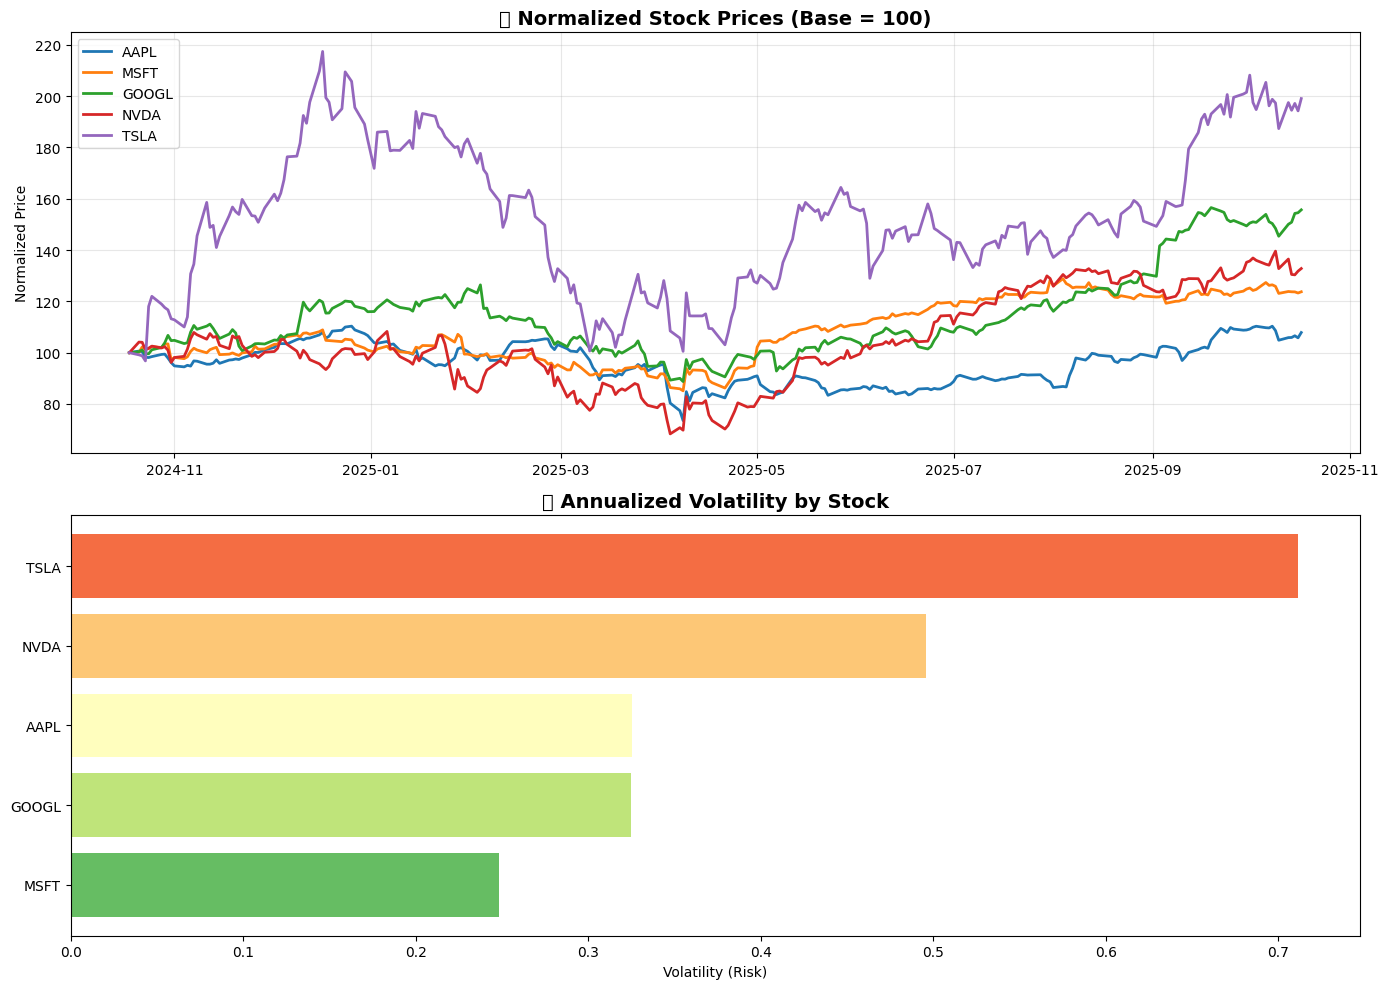

Data fetching and visualization working correctly!


In [7]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Normalized price trends
ax1 = axes[0]
for ticker in stock_data.keys():
    hist = stock_data[ticker]['history']
    normalized = (hist['Close'] / hist['Close'].iloc[0]) * 100
    ax1.plot(normalized.index, normalized.values, label=ticker, linewidth=2)

ax1.set_title('📈 Normalized Stock Prices (Base = 100)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Normalized Price')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Volatility comparison
ax2 = axes[1]
volatilities = summary_stats['volatility'].sort_values()
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(volatilities)))
ax2.barh(volatilities.index, volatilities.values, color=colors)
ax2.set_title('📊 Annualized Volatility by Stock', fontsize=14, fontweight='bold')
ax2.set_xlabel('Volatility (Risk)')

plt.tight_layout()
plt.show()

print("Data fetching and visualization working correctly!")

In [8]:
!pip install -q newsapi-python tweepy

In [9]:
from newsapi import NewsApiClient
import tweepy
import time

try:
    NEWSAPI_KEY = userdata.get('NEWSAPI_KEY')
    print("NewsAPI key loaded from Colab Secrets")
except:
    print("NewsAPI Key Setup:")
    print("   1. Go to: https://newsapi.org/register")
    print("   2. Sign up (free)")
    print("   3. Copy your API key")
    print("   4. Add to Colab Secrets as 'NEWSAPI_KEY' OR paste below\n")
    NEWSAPI_KEY = input("Paste your NewsAPI key here: ").strip()

# Initialize NewsAPI client
newsapi = NewsApiClient(api_key=NEWSAPI_KEY)

# Test NewsAPI connection
try:
    test_news = newsapi.get_everything(q='stocks', page_size=1)
    print(f"NewsAPI connected! Status: {test_news['status']}")
except Exception as e:
    print(f"NewsAPI Error: {e}")
    print("   Check your API key at: https://newsapi.org/account")

print("\n" + "="*60)

print("🔧 Twitter API Setup (OPTIONAL - Enhanced sentiment analysis)")
print("\n To get Twitter API credentials:")
print("   1. Go to: https://developer.twitter.com/en/portal/dashboard")
print("   2. Sign up for Developer Account (Free tier available)")
print("   3. Create a Project & App")
print("   4. Generate API Key, API Secret, Bearer Token")
print("   5. Note: Free tier has rate limits but works for this project\n")

use_twitter = input("Do you want to use Twitter API? (y/n): ").strip().lower()

twitter_client = None
if use_twitter == 'y':
    try:
        TWITTER_BEARER_TOKEN = userdata.get('TWITTER_BEARER_TOKEN')
        print("Twitter Bearer Token loaded from Secrets")
    except:
        print("\nTwitter Authentication:")
        print("   You need a Bearer Token (easiest option)")
        TWITTER_BEARER_TOKEN = input("Paste your Twitter Bearer Token: ").strip()

    try:
        twitter_client = tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN)

        test_tweet = twitter_client.search_recent_tweets(
            query="stocks",
            max_results=10
        )
        print("Twitter API connected successfully!")
        print(f"   Found {len(test_tweet.data)} test tweets")

    except Exception as e:
        print(f"Twitter connection failed: {e}")
        print("   Continuing with NewsAPI only...")
        twitter_client = None
else:
    print("⏭Skipping Twitter - using NewsAPI only")

print("\nAPI configuration complete!")

NewsAPI key loaded from Colab Secrets
NewsAPI connected! Status: ok

🔧 Twitter API Setup (OPTIONAL - Enhanced sentiment analysis)

 To get Twitter API credentials:
   1. Go to: https://developer.twitter.com/en/portal/dashboard
   2. Sign up for Developer Account (Free tier available)
   3. Create a Project & App
   4. Generate API Key, API Secret, Bearer Token
   5. Note: Free tier has rate limits but works for this project

Do you want to use Twitter API? (y/n): y
Twitter Bearer Token loaded from Secrets
Twitter API connected successfully!
   Found 10 test tweets

API configuration complete!


In [10]:
class SentimentAnalyzer:
    """
    Fetches news from NewsAPI and tweets from Twitter, analyzes sentiment using Gemini
    """

    def __init__(self, llm, newsapi_client, twitter_client=None):
        """
        Args:
            llm: LangChain Gemini LLM instance
            newsapi_client: NewsAPI client
            twitter_client: Tweepy Twitter client (optional)
        """
        self.llm = llm
        self.newsapi = newsapi_client
        self.twitter = twitter_client
        self.news_cache = {}

    def fetch_newsapi_articles(self, ticker, company_name=None, max_results=10):
        """
        Fetch news articles from NewsAPI

        Args:
            ticker: Stock symbol (e.g., 'AAPL')
            company_name: Full company name (e.g., 'Apple Inc')
            max_results: Number of articles to fetch
        """
        print(f"  📰 Fetching NewsAPI articles for {ticker}...")

        try:
            query = company_name if company_name else f"{ticker} stock"

            from_date = (datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')

            response = self.newsapi.get_everything(
                q=query,
                from_param=from_date,
                language='en',
                sort_by='relevancy',
                page_size=max_results
            )

            articles = []
            if response['status'] == 'ok':
                for article in response['articles']:
                    articles.append({
                        'title': article.get('title', ''),
                        'description': article.get('description', ''),
                        'content': article.get('content', ''),
                        'source': article.get('source', {}).get('name', 'Unknown'),
                        'published_at': article.get('publishedAt', ''),
                        'url': article.get('url', '')
                    })

            print(f"     Found {len(articles)} NewsAPI articles")
            return articles

        except Exception as e:
            print(f"     NewsAPI Error: {str(e)}")
            return []

    def fetch_twitter_sentiment(self, ticker, max_results=100):
        """
        Fetch tweets about a stock ticker

        Args:
            ticker: Stock symbol (e.g., 'AAPL', 'TSLA')
            max_results: Number of tweets to fetch (10-100 for free tier)
        """
        if not self.twitter:
            return []

        print(f"  🐦 Fetching Twitter posts for ${ticker}...")

        try:
            query = f"${ticker} -is:retweet lang:en"

            tweets_response = self.twitter.search_recent_tweets(
                query=query,
                max_results=min(max_results, 100),
                tweet_fields=['created_at', 'public_metrics', 'text']
            )

            tweets = []
            if tweets_response.data:
                for tweet in tweets_response.data:
                    tweets.append({
                        'text': tweet.text,
                        'created_at': tweet.created_at,
                        'likes': tweet.public_metrics['like_count'],
                        'retweets': tweet.public_metrics['retweet_count'],
                        'engagement': tweet.public_metrics['like_count'] + tweet.public_metrics['retweet_count']
                    })

            tweets = sorted(tweets, key=lambda x: x['engagement'], reverse=True)

            print(f"     Found {len(tweets)} tweets for ${ticker}")
            return tweets

        except tweepy.errors.TooManyRequests:
            print(f"     Twitter rate limit reached. Try again in 15 minutes.")
            return []
        except Exception as e:
            print(f"     Twitter Error: {str(e)}")
            return []

    def analyze_sentiment(self, ticker, articles, tweets=None):
        """
        Analyze sentiment using Gemini LLM

        Returns: {
            'sentiment_score': float (-1 to 1),
            'confidence': str,
            'reasoning': str,
            'news_sentiment': float,
            'social_sentiment': float
        }
        """
        if not articles and not tweets:
            print(f"  No content to analyze for {ticker}")
            return {
                'sentiment_score': 0.0,
                'confidence': 'low',
                'reasoning': 'No data',
                'news_sentiment': 0.0,
                'social_sentiment': 0.0
            }

        news_text = ""
        if articles:
            news_text += "FINANCIAL NEWS ARTICLES:\n"
            for i, article in enumerate(articles[:5], 1):
                news_text += f"{i}. [{article['source']}] {article['title']}\n"
                if article['description']:
                    news_text += f"   {article['description'][:150]}...\n\n"

        if tweets:
            news_text += "\nTWITTER MARKET SENTIMENT (Top Engaging Tweets):\n"
            for i, tweet in enumerate(tweets[:10], 1):
                news_text += f"{i}. {tweet['text'][:200]}... "
                news_text += f"[{tweet['likes']} | {tweet['retweets']}]\n\n"

        prompt = f"""You are an expert financial sentiment analyzer for stock market investments.

Analyze the following content about {ticker} stock and determine OVERALL investor sentiment.

{news_text}

ANALYSIS REQUIREMENTS:
1. **News Sentiment**: Rate -1.0 (very negative) to +1.0 (very positive) based on financial news
2. **Social Sentiment**: Rate -1.0 to +1.0 based on Twitter discussions (if available)
3. **Overall Sentiment**: Weighted combination (60% news, 40% social if both available)
4. **Confidence**: HIGH (15+ sources), MEDIUM (5-14 sources), LOW (<5 sources)
5. **Reasoning**: 1-2 sentences explaining the key sentiment drivers

Consider:
- Company financial performance and earnings
- Product launches, innovations, partnerships
- Market trends and analyst ratings
- Regulatory news or legal issues
- Social media buzz and retail investor sentiment
- Engagement metrics on social posts (high engagement = stronger signal)

FORMAT YOUR RESPONSE EXACTLY AS:
News_Sentiment: [number -1.0 to +1.0]
Social_Sentiment: [number -1.0 to +1.0, or N/A if no Twitter data]
Overall_Score: [number -1.0 to +1.0]
Confidence: [HIGH/MEDIUM/LOW]
Reasoning: [1-2 sentence explanation of key drivers]"""

        try:
            response = self.llm.invoke(prompt)
            response_text = response.content

            result = self._parse_sentiment_response(response_text)
            result['ticker'] = ticker

            print(f"     📊 Overall Sentiment: {result['sentiment_score']:.2f}")
            print(f"        News: {result['news_sentiment']:.2f} | Social: {result['social_sentiment']:.2f}")
            print(f"        Confidence: {result['confidence'].upper()}")

            return result

        except Exception as e:
            print(f"     Sentiment Analysis Error: {str(e)}")
            return {
                'sentiment_score': 0.0,
                'confidence': 'low',
                'reasoning': f'Error: {str(e)}',
                'news_sentiment': 0.0,
                'social_sentiment': 0.0
            }

    def _parse_sentiment_response(self, response_text):
        """Parse LLM sentiment response"""
        result = {
            'sentiment_score': 0.0,
            'news_sentiment': 0.0,
            'social_sentiment': 0.0,
            'confidence': 'medium',
            'reasoning': 'Could not parse response'
        }

        try:
            lines = response_text.split('\n')

            for line in lines:
                line_lower = line.lower()

                if 'news_sentiment:' in line_lower or 'news sentiment:' in line_lower:
                    score_str = line.split(':')[1].strip()
                    try:
                        result['news_sentiment'] = max(-1.0, min(1.0, float(score_str)))
                    except:
                        pass

                elif 'social_sentiment:' in line_lower or 'social sentiment:' in line_lower:
                    score_str = line.split(':')[1].strip()
                    if 'n/a' not in score_str.lower():
                        try:
                            result['social_sentiment'] = max(-1.0, min(1.0, float(score_str)))
                        except:
                            pass

                elif 'overall_score:' in line_lower or 'overall score:' in line_lower:
                    score_str = line.split(':')[1].strip()
                    result['sentiment_score'] = max(-1.0, min(1.0, float(score_str)))

                elif 'confidence:' in line_lower:
                    confidence = line.split(':')[1].strip().lower()
                    result['confidence'] = confidence

                elif 'reasoning:' in line_lower:
                    reasoning = line.split(':', 1)[1].strip()
                    result['reasoning'] = reasoning

            return result

        except Exception as e:
            print(f"       Parse error: {e}")
            return result

    def get_sentiment_for_portfolio(self, tickers, company_names=None):
        """
        Analyze sentiment for multiple stocks

        Args:
            tickers: List of stock symbols
            company_names: Optional dict mapping ticker to company name
                          e.g., {'AAPL': 'Apple Inc', 'MSFT': 'Microsoft'}

        Returns: DataFrame with sentiment analysis
        """
        if company_names is None:
            company_names = {}

        sentiment_data = {}

        for ticker in tickers:
            print(f"\n🔍 Analyzing {ticker}...")

            company_name = company_names.get(ticker)

            articles = self.fetch_newsapi_articles(ticker, company_name, max_results=10)

            tweets = self.fetch_twitter_sentiment(ticker, max_results=50) if self.twitter else []

            sentiment_result = self.analyze_sentiment(ticker, articles, tweets)

            sentiment_data[ticker] = {
                'sentiment_score': sentiment_result['sentiment_score'],
                'news_sentiment': sentiment_result['news_sentiment'],
                'social_sentiment': sentiment_result['social_sentiment'],
                'confidence': sentiment_result['confidence'],
                'reasoning': sentiment_result['reasoning'],
                'num_articles': len(articles),
                'num_tweets': len(tweets),
                'total_sources': len(articles) + len(tweets)
            }

            time.sleep(1)

        return pd.DataFrame(sentiment_data).T

print("Enhanced SentimentAnalyzer with Twitter support defined!")

Enhanced SentimentAnalyzer with Twitter support defined!


In [11]:
print("TESTING SENTIMENT ANALYSIS")
print("="*60)

company_map = {
    'AAPL': 'Apple Inc',
    'MSFT': 'Microsoft Corporation',
    'GOOGL': 'Google Alphabet',
    'NVDA': 'NVIDIA Corporation',
    'TSLA': 'Tesla Inc'
}

sentiment_analyzer = SentimentAnalyzer(llm, newsapi, twitter_client)

test_tickers = ['AAPL', 'NVDA', 'TSLA']

sentiment_results = sentiment_analyzer.get_sentiment_for_portfolio(
    test_tickers,
    company_names=company_map
)

print("\n" + "="*60)
print("SENTIMENT ANALYSIS RESULTS")
print("="*60)
print(sentiment_results)

TESTING SENTIMENT ANALYSIS

🔍 Analyzing AAPL...
  📰 Fetching NewsAPI articles for AAPL...
     Found 10 NewsAPI articles
  🐦 Fetching Twitter posts for $AAPL...
     Twitter rate limit reached. Try again in 15 minutes.
     📊 Overall Sentiment: 0.05
        News: 0.05 | Social: 0.00
        Confidence: LOW

🔍 Analyzing NVDA...
  📰 Fetching NewsAPI articles for NVDA...
     Found 10 NewsAPI articles
  🐦 Fetching Twitter posts for $NVDA...
     Twitter rate limit reached. Try again in 15 minutes.
     📊 Overall Sentiment: 0.85
        News: 0.85 | Social: 0.00
        Confidence: MEDIUM

🔍 Analyzing TSLA...
  📰 Fetching NewsAPI articles for TSLA...
     Found 10 NewsAPI articles
  🐦 Fetching Twitter posts for $TSLA...
     Twitter rate limit reached. Try again in 15 minutes.
     📊 Overall Sentiment: -0.15
        News: -0.15 | Social: 0.00
        Confidence: MEDIUM

SENTIMENT ANALYSIS RESULTS
     sentiment_score news_sentiment social_sentiment confidence  \
AAPL            0.05       

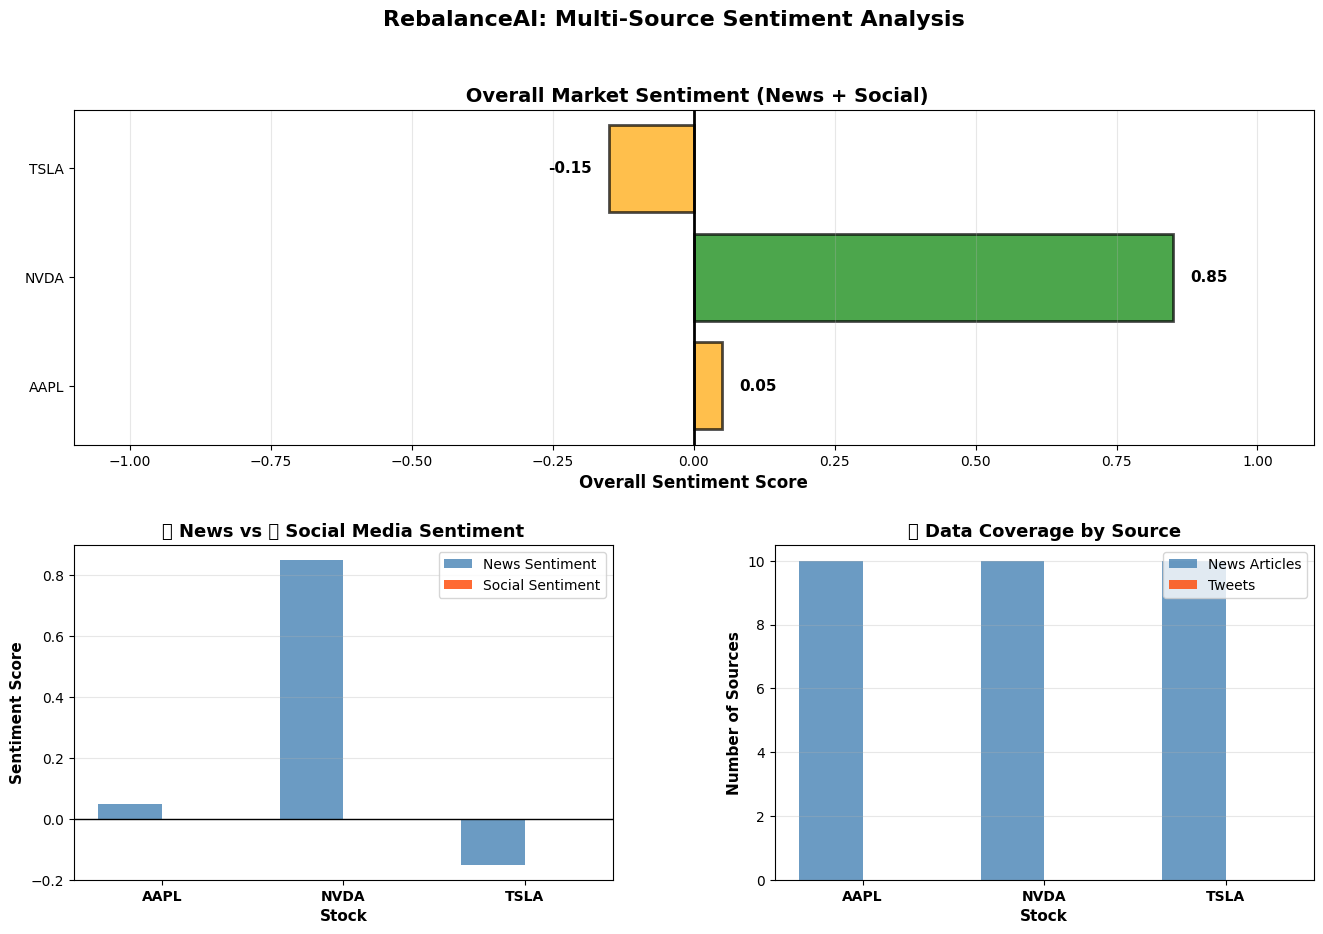

Multi-source sentiment analysis complete!

Key Insights:
  • AAPL: Investor sentiment is slightly positive, driven by the endorsement from influential investors like N...
  • NVDA: The news overwhelmingly highlights NVIDIA's market dominance in AI, strong partnerships, and positiv...
  • TSLA: Investor sentiment is slightly negative due to a prominent analyst's strong criticism of TSLA's valu...


In [12]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :])
colors = ['green' if score > 0.2 else 'red' if score < -0.2 else 'orange'
          for score in sentiment_results['sentiment_score']]

bars = ax1.barh(sentiment_results.index,
                sentiment_results['sentiment_score'],
                color=colors,
                alpha=0.7,
                edgecolor='black',
                linewidth=2)

for i, (ticker, score) in enumerate(sentiment_results['sentiment_score'].items()):
    ax1.text(score + 0.03 if score > 0 else score - 0.03, i,
            f'{score:.2f}',
            va='center',
            ha='left' if score > 0 else 'right',
            fontweight='bold',
            fontsize=11)

ax1.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax1.set_xlabel('Overall Sentiment Score', fontsize=12, fontweight='bold')
ax1.set_title(' Overall Market Sentiment (News + Social)', fontsize=14, fontweight='bold')
ax1.set_xlim(-1.1, 1.1)
ax1.grid(axis='x', alpha=0.3)

ax2 = fig.add_subplot(gs[1, 0])
x = np.arange(len(sentiment_results))
width = 0.35

ax2.bar(x - width/2, sentiment_results['news_sentiment'], width,
        label='News Sentiment', color='steelblue', alpha=0.8)
ax2.bar(x + width/2, sentiment_results['social_sentiment'], width,
        label='Social Sentiment', color='orangered', alpha=0.8)

ax2.set_xlabel('Stock', fontsize=11, fontweight='bold')
ax2.set_ylabel('Sentiment Score', fontsize=11, fontweight='bold')
ax2.set_title('📰 News vs 🐦 Social Media Sentiment', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(sentiment_results.index, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

ax3 = fig.add_subplot(gs[1, 1])
source_data = sentiment_results[['num_articles', 'num_tweets']].fillna(0)
x = np.arange(len(source_data))

ax3.bar(x - width/2, source_data['num_articles'], width,
        label='News Articles', color='steelblue', alpha=0.8)
ax3.bar(x + width/2, source_data['num_tweets'], width,
        label='Tweets', color='orangered', alpha=0.8)

ax3.set_xlabel('Stock', fontsize=11, fontweight='bold')
ax3.set_ylabel('Number of Sources', fontsize=11, fontweight='bold')
ax3.set_title('📊 Data Coverage by Source', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(source_data.index, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

plt.suptitle('RebalanceAI: Multi-Source Sentiment Analysis',
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

print("Multi-source sentiment analysis complete!")
print("\nKey Insights:")
for ticker in sentiment_results.index:
    row = sentiment_results.loc[ticker]
    print(f"  • {ticker}: {row['reasoning'][:100]}...")

# Quantative metrics

In [13]:
class QuantMetricsCalculator:
    """
    Calculate financial metrics for portfolio analysis
    """

    def __init__(self, stock_data):
        """
        Args:
            stock_data: Dictionary from StockDataFetcher with stock history
        """
        self.stock_data = stock_data
        self.tickers = list(stock_data.keys())
        self.returns_df = self._build_returns_dataframe()

    def _build_returns_dataframe(self):
        """Build a DataFrame of daily returns for all stocks"""
        returns_dict = {}

        for ticker in self.tickers:
            returns_dict[ticker] = self.stock_data[ticker]['returns']

        returns_df = pd.DataFrame(returns_dict)
        returns_df = returns_df.dropna()

        return returns_df

    def calculate_sharpe_ratio(self, ticker, risk_free_rate=0.02):
        """
        Calculate Sharpe Ratio for a stock

        Sharpe Ratio = (Return - Risk-Free Rate) / Volatility
        Higher is better (more return per unit of risk)

        Args:
            ticker: Stock symbol
            risk_free_rate: Annual risk-free rate (default 2%)
        """
        returns = self.returns_df[ticker]

        annual_return = returns.mean() * 252
        annual_volatility = returns.std() * np.sqrt(252)

        if annual_volatility == 0:
            return 0

        sharpe = (annual_return - risk_free_rate) / annual_volatility
        return sharpe

    def calculate_volatility(self, ticker):
        """
        Calculate annualized volatility (standard deviation of returns)
        Lower is less risky
        """
        returns = self.returns_df[ticker]
        annual_volatility = returns.std() * np.sqrt(252)
        return annual_volatility

    def calculate_max_drawdown(self, ticker):
        """
        Calculate maximum drawdown (largest peak-to-trough decline)

        Max Drawdown measures worst loss from peak
        Lower (more negative) is worse
        """
        hist = self.stock_data[ticker]['history']
        prices = hist['Close']

        cumulative = (1 + prices.pct_change()).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max

        max_dd = drawdown.min()
        return max_dd

    def calculate_beta(self, ticker, market_ticker='SPY'):
        """
        Calculate Beta (sensitivity to market movements)

        Beta = 1: Moves with market
        Beta > 1: More volatile than market
        Beta < 1: Less volatile than market

        Args:
            ticker: Stock symbol
            market_ticker: Market benchmark (default: SPY for S&P 500)
        """
        try:
            market = yf.Ticker(market_ticker)
            market_hist = market.history(period='1y')
            market_returns = market_hist['Close'].pct_change().dropna()

            stock_returns = self.returns_df[ticker]

            common_dates = stock_returns.index.intersection(market_returns.index)
            stock_aligned = stock_returns.loc[common_dates]
            market_aligned = market_returns.loc[common_dates]

            covariance = np.cov(stock_aligned, market_aligned)[0][1]
            market_variance = np.var(market_aligned)

            beta = covariance / market_variance if market_variance != 0 else 1.0
            return beta

        except Exception as e:
            print(f"    Could not calculate beta for {ticker}: {e}")
            return 1.0

    def calculate_correlation_matrix(self):
        """
        Calculate correlation matrix between all stocks

        Shows how stocks move together:
        1.0 = perfect positive correlation
        0.0 = no correlation
        -1.0 = perfect negative correlation
        """
        correlation_matrix = self.returns_df.corr()
        return correlation_matrix

    def calculate_all_metrics(self, risk_free_rate=0.02):
        """
        Calculate all metrics for all stocks

        Returns: DataFrame with comprehensive metrics
        """
        print("Calculating quantitative metrics...")

        metrics = {}

        for ticker in self.tickers:
            print(f"  Computing metrics for {ticker}...", end=" ")

            try:
                metrics[ticker] = {
                    'annual_return': self.returns_df[ticker].mean() * 252,
                    'volatility': self.calculate_volatility(ticker),
                    'sharpe_ratio': self.calculate_sharpe_ratio(ticker, risk_free_rate),
                    'max_drawdown': self.calculate_max_drawdown(ticker),
                    'beta': self.calculate_beta(ticker),
                    'current_price': self.stock_data[ticker]['current_price']
                }
                print(" done")

            except Exception as e:
                print(f"Error: {e}")
                metrics[ticker] = {
                    'annual_return': 0,
                    'volatility': 0,
                    'sharpe_ratio': 0,
                    'max_drawdown': 0,
                    'beta': 1.0,
                    'current_price': 0
                }

        metrics_df = pd.DataFrame(metrics).T

        print("\nAll metrics calculated!")
        return metrics_df

    def get_portfolio_metrics(self, weights):
        """
        Calculate portfolio-level metrics given weights

        Args:
            weights: Dict of {ticker: weight} (weights should sum to 1.0)

        Returns: Dict with portfolio metrics
        """
        weight_array = np.array([weights.get(ticker, 0) for ticker in self.tickers])

        returns_mean = self.returns_df.mean()
        portfolio_return = np.sum(returns_mean * weight_array) * 252

        cov_matrix = self.returns_df.cov() * 252
        portfolio_variance = np.dot(weight_array.T, np.dot(cov_matrix, weight_array))
        portfolio_volatility = np.sqrt(portfolio_variance)

        sharpe = (portfolio_return - 0.02) / portfolio_volatility if portfolio_volatility > 0 else 0

        return {
            'return': portfolio_return,
            'volatility': portfolio_volatility,
            'sharpe_ratio': sharpe
        }

print("QuantMetricsCalculator class defined!")

QuantMetricsCalculator class defined!


In [14]:
print("TESTING QUANTITATIVE METRICS")
print("="*60)

quant_calculator = QuantMetricsCalculator(stock_data)

metrics_df = quant_calculator.calculate_all_metrics(risk_free_rate=0.02)

print("\n" + "="*60)
print("QUANTITATIVE METRICS SUMMARY")
print("="*60)
print(metrics_df.round(4))

print("\n" + "="*60)
print("CORRELATION MATRIX")
print("="*60)
correlation_matrix = quant_calculator.calculate_correlation_matrix()
print(correlation_matrix.round(3))

TESTING QUANTITATIVE METRICS
Calculating quantitative metrics...
  Computing metrics for AAPL...  done
  Computing metrics for MSFT...  done
  Computing metrics for GOOGL...  done
  Computing metrics for NVDA...  done
  Computing metrics for TSLA...  done

All metrics calculated!

QUANTITATIVE METRICS SUMMARY
       annual_return  volatility  sharpe_ratio  max_drawdown    beta  \
AAPL          0.1286      0.3254        0.3339       -0.3336  1.2502   
MSFT          0.2460      0.2481        0.9111       -0.2183  0.9198   
GOOGL         0.5006      0.3246        1.4804       -0.2981  1.0200   
NVDA          0.4103      0.4958        0.7873       -0.3688  1.8426   
TSLA          0.9447      0.7118        1.2992       -0.5377  2.3305   

       current_price  
AAPL          252.29  
MSFT          513.58  
GOOGL         253.30  
NVDA          183.22  
TSLA          439.31  

CORRELATION MATRIX
        AAPL   MSFT  GOOGL   NVDA   TSLA
AAPL   1.000  0.518  0.491  0.442  0.482
MSFT   0.518  1.

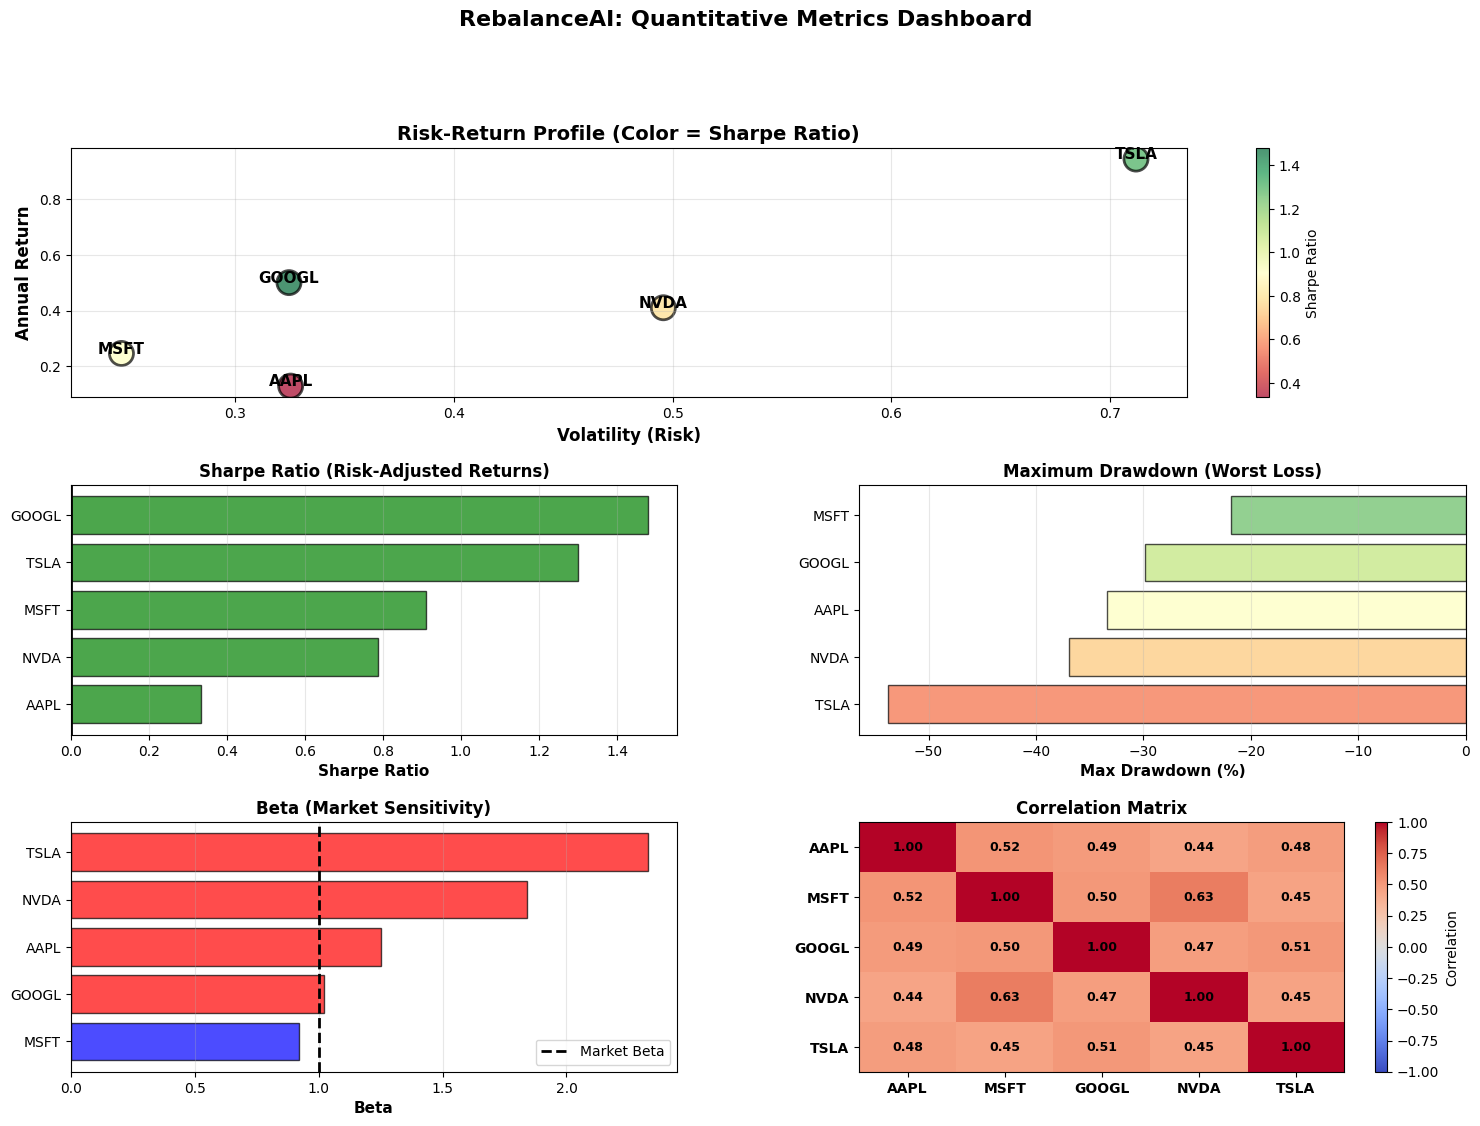

Quantitative analysis complete!


In [15]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :])
scatter = ax1.scatter(metrics_df['volatility'],
                      metrics_df['annual_return'],
                      s=300,
                      c=metrics_df['sharpe_ratio'],
                      cmap='RdYlGn',
                      alpha=0.7,
                      edgecolors='black',
                      linewidth=2)

for ticker in metrics_df.index:
    ax1.annotate(ticker,
                (metrics_df.loc[ticker, 'volatility'],
                 metrics_df.loc[ticker, 'annual_return']),
                fontsize=11,
                fontweight='bold',
                ha='center')

ax1.set_xlabel('Volatility (Risk)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Annual Return', fontsize=12, fontweight='bold')
ax1.set_title('Risk-Return Profile (Color = Sharpe Ratio)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Sharpe Ratio')

ax2 = fig.add_subplot(gs[1, 0])
sharpe_sorted = metrics_df['sharpe_ratio'].sort_values()
colors_sharpe = ['green' if x > 0 else 'red' for x in sharpe_sorted]
ax2.barh(sharpe_sorted.index, sharpe_sorted.values, color=colors_sharpe, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Sharpe Ratio', fontsize=11, fontweight='bold')
ax2.set_title('Sharpe Ratio (Risk-Adjusted Returns)', fontsize=12, fontweight='bold')
ax2.axvline(x=0, color='black', linewidth=2)
ax2.grid(axis='x', alpha=0.3)

ax3 = fig.add_subplot(gs[1, 1])
drawdown_sorted = metrics_df['max_drawdown'].sort_values()
colors_dd = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(drawdown_sorted)))
ax3.barh(drawdown_sorted.index, drawdown_sorted.values * 100, color=colors_dd, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Max Drawdown (%)', fontsize=11, fontweight='bold')
ax3.set_title('Maximum Drawdown (Worst Loss)', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

ax4 = fig.add_subplot(gs[2, 0])
beta_sorted = metrics_df['beta'].sort_values()
colors_beta = ['blue' if x < 1 else 'red' for x in beta_sorted]
ax4.barh(beta_sorted.index, beta_sorted.values, color=colors_beta, alpha=0.7, edgecolor='black')
ax4.axvline(x=1.0, color='black', linestyle='--', linewidth=2, label='Market Beta')
ax4.set_xlabel('Beta', fontsize=11, fontweight='bold')
ax4.set_title('Beta (Market Sensitivity)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(axis='x', alpha=0.3)

ax5 = fig.add_subplot(gs[2, 1])
im = ax5.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax5.set_xticks(np.arange(len(correlation_matrix)))
ax5.set_yticks(np.arange(len(correlation_matrix)))
ax5.set_xticklabels(correlation_matrix.columns, fontweight='bold')
ax5.set_yticklabels(correlation_matrix.index, fontweight='bold')

for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        text = ax5.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=9, fontweight='bold')

ax5.set_title('Correlation Matrix', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax5, label='Correlation')

plt.suptitle('RebalanceAI: Quantitative Metrics Dashboard',
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

print("Quantitative analysis complete!")

In [16]:
print("TESTING PORTFOLIO METRICS")
print("="*60)

equal_weights = {ticker: 1.0/len(test_tickers) for ticker in test_tickers}

print(f"\nEqual-Weighted Portfolio ({len(test_tickers)} stocks)")
print(f"Weights: {equal_weights}")

portfolio_metrics = quant_calculator.get_portfolio_metrics(equal_weights)

print(f"\nPortfolio Performance:")
print(f"  Expected Return: {portfolio_metrics['return']:.2%}")
print(f"  Volatility (Risk): {portfolio_metrics['volatility']:.2%}")
print(f"  Sharpe Ratio: {portfolio_metrics['sharpe_ratio']:.3f}")

print("\nPortfolio metrics calculation working!")

TESTING PORTFOLIO METRICS

Equal-Weighted Portfolio (3 stocks)
Weights: {'AAPL': 0.3333333333333333, 'NVDA': 0.3333333333333333, 'TSLA': 0.3333333333333333}

Portfolio Performance:
  Expected Return: 49.46%
  Volatility (Risk): 41.41%
  Sharpe Ratio: 1.146

Portfolio metrics calculation working!


# Optimizer

In [17]:
from scipy.optimize import minimize

class PortfolioOptimizer:
    """
    Optimize portfolio weights using modern portfolio theory
    """

    def __init__(self, quant_calculator, sentiment_results=None):
        """
        Args:
            quant_calculator: QuantMetricsCalculator instance
            sentiment_results: Optional DataFrame with sentiment scores
        """
        self.quant_calc = quant_calculator
        self.sentiment = sentiment_results
        self.tickers = quant_calculator.tickers
        self.returns_df = quant_calculator.returns_df
        self.cov_matrix = self.returns_df.cov() * 252
        self.mean_returns = self.returns_df.mean() * 252

    def _portfolio_stats(self, weights):
        """Calculate portfolio return, volatility, and Sharpe ratio"""
        portfolio_return = np.sum(self.mean_returns * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - 0.02) / portfolio_volatility if portfolio_volatility > 0 else 0

        return portfolio_return, portfolio_volatility, sharpe_ratio

    def _negative_sharpe(self, weights):
        """Objective function: Negative Sharpe (we minimize this to maximize Sharpe)"""
        _, _, sharpe = self._portfolio_stats(weights)
        return -sharpe

    def optimize_max_sharpe(self, risk_tolerance='moderate'):
        """
        Optimize for maximum Sharpe ratio

        Args:
            risk_tolerance: 'conservative', 'moderate', or 'aggressive'

        Returns: Optimal weights dict
        """
        print(f"Optimizing portfolio (Max Sharpe, {risk_tolerance} risk)...")

        n_assets = len(self.tickers)


        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}


        if risk_tolerance == 'conservative':
            bounds = tuple((0.05, 0.30) for _ in range(n_assets))
        elif risk_tolerance == 'moderate':
            bounds = tuple((0.05, 0.40) for _ in range(n_assets))
        else:
            bounds = tuple((0.0, 0.60) for _ in range(n_assets))


        initial_weights = np.array([1.0/n_assets] * n_assets)

        result = minimize(
            self._negative_sharpe,
            initial_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000}
        )

        if result.success:
            optimal_weights = result.x
            weights_dict = {ticker: weight for ticker, weight in zip(self.tickers, optimal_weights)}

            ret, vol, sharpe = self._portfolio_stats(optimal_weights)

            print(f"  Optimization successful!")
            print(f"     Expected Return: {ret:.2%}")
            print(f"     Volatility: {vol:.2%}")
            print(f"     Sharpe Ratio: {sharpe:.3f}")

            return weights_dict
        else:
            print(f"  Optimization failed, using equal weights")
            return {ticker: 1.0/n_assets for ticker in self.tickers}

    def optimize_min_volatility(self, target_return=None):
        """
        Optimize for minimum volatility (conservative approach)

        Args:
            target_return: Optional target return constraint

        Returns: Optimal weights dict
        """
        print(f"Optimizing portfolio (Min Volatility)...")

        n_assets = len(self.tickers)

        def portfolio_volatility(weights):
            return np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))

        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

        if target_return:
            constraints.append({
                'type': 'eq',
                'fun': lambda w: np.sum(self.mean_returns * w) - target_return
            })

        bounds = tuple((0.0, 0.40) for _ in range(n_assets))

        initial_weights = np.array([1.0/n_assets] * n_assets)

        result = minimize(
            portfolio_volatility,
            initial_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000}
        )

        if result.success:
            optimal_weights = result.x
            weights_dict = {ticker: weight for ticker, weight in zip(self.tickers, optimal_weights)}

            ret, vol, sharpe = self._portfolio_stats(optimal_weights)

            print(f"  Optimization successful!")
            print(f"     Expected Return: {ret:.2%}")
            print(f"     Volatility: {vol:.2%}")
            print(f"     Sharpe Ratio: {sharpe:.3f}")

            return weights_dict
        else:
            print(f"  Optimization failed, using equal weights")
            return {ticker: 1.0/n_assets for ticker in self.tickers}

    def optimize_with_sentiment(self, sentiment_weight=0.3, risk_tolerance='moderate'):
        """
        Optimize portfolio incorporating sentiment scores

        Args:
            sentiment_weight: How much to weight sentiment (0-1)
            risk_tolerance: 'conservative', 'moderate', or 'aggressive'

        Returns: Optimal weights dict with sentiment boost
        """
        print(f"Optimizing with sentiment (α={sentiment_weight})...")

        if self.sentiment is None:
            print("  No sentiment data, falling back to max Sharpe")
            return self.optimize_max_sharpe(risk_tolerance)

        n_assets = len(self.tickers)

        adjusted_returns = self.mean_returns.copy()

        for ticker in self.tickers:
            if ticker in self.sentiment.index:
                sentiment_score = self.sentiment.loc[ticker, 'sentiment_score']
                sentiment_adjustment = sentiment_score * 0.10
                adjusted_returns[ticker] = adjusted_returns[ticker] * (1 + sentiment_adjustment)

        print(f"  Sentiment adjustments applied:")
        for ticker in self.tickers:
            if ticker in self.sentiment.index:
                sent = self.sentiment.loc[ticker, 'sentiment_score']
                print(f"     {ticker}: {sent:+.2f} sentiment")

        def sentiment_adjusted_objective(weights):
            ret, vol, sharpe = self._portfolio_stats(weights)

            sentiment_contrib = 0
            if self.sentiment is not None:
                for i, ticker in enumerate(self.tickers):
                    if ticker in self.sentiment.index:
                        sentiment_contrib += weights[i] * self.sentiment.loc[ticker, 'sentiment_score']

            combined_score = (1 - sentiment_weight) * sharpe + sentiment_weight * sentiment_contrib

            return -combined_score

        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

        if risk_tolerance == 'conservative':
            bounds = tuple((0.05, 0.30) for _ in range(n_assets))
        elif risk_tolerance == 'moderate':
            bounds = tuple((0.05, 0.40) for _ in range(n_assets))
        else:
            bounds = tuple((0.0, 0.60) for _ in range(n_assets))

        initial_weights = np.array([1.0/n_assets] * n_assets)

        result = minimize(
            sentiment_adjusted_objective,
            initial_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000}
        )

        if result.success:
            optimal_weights = result.x
            weights_dict = {ticker: weight for ticker, weight in zip(self.tickers, optimal_weights)}

            ret, vol, sharpe = self._portfolio_stats(optimal_weights)

            print(f"  Sentiment-adjusted optimization successful!")
            print(f"     Expected Return: {ret:.2%}")
            print(f"     Volatility: {vol:.2%}")
            print(f"     Sharpe Ratio: {sharpe:.3f}")

            return weights_dict
        else:
            print(f"  Optimization failed, using max Sharpe")
            return self.optimize_max_sharpe(risk_tolerance)

    def generate_efficient_frontier(self, n_portfolios=50):
        """
        Generate efficient frontier (optimal portfolios at different risk levels)

        Returns: DataFrame with frontier portfolios
        """
        print(f"Generating efficient frontier ({n_portfolios} portfolios)...")

        n_assets = len(self.tickers)

        min_return = self.mean_returns.min()
        max_return = self.mean_returns.max()
        target_returns = np.linspace(min_return, max_return, n_portfolios)

        frontier_data = []

        for target_ret in target_returns:
            weights = self.optimize_min_volatility(target_return=target_ret)
            weights_array = np.array([weights[ticker] for ticker in self.tickers])
            ret, vol, sharpe = self._portfolio_stats(weights_array)

            frontier_data.append({
                'return': ret,
                'volatility': vol,
                'sharpe': sharpe
            })

        frontier_df = pd.DataFrame(frontier_data)
        print(f"  Efficient frontier generated!")

        return frontier_df

print("PortfolioOptimizer class defined!")

PortfolioOptimizer class defined!


In [18]:
print("TESTING PORTFOLIO OPTIMIZATION")
print("="*60)

optimizer = PortfolioOptimizer(quant_calculator, sentiment_results)

equal_weights = {ticker: 1.0/len(test_tickers) for ticker in test_tickers}
print("\nStrategy 1: Equal-Weighted Portfolio")
print(f"Weights: {equal_weights}")
equal_metrics = quant_calculator.get_portfolio_metrics(equal_weights)
print(f"Return: {equal_metrics['return']:.2%} | Volatility: {equal_metrics['volatility']:.2%} | Sharpe: {equal_metrics['sharpe_ratio']:.3f}")

print("\n" + "="*60)
max_sharpe_weights = optimizer.optimize_max_sharpe(risk_tolerance='moderate')
print(f"\nStrategy 2: Max Sharpe Weights")
for ticker, weight in sorted(max_sharpe_weights.items(), key=lambda x: x[1], reverse=True):
    print(f"  {ticker}: {weight:.1%}")

print("\n" + "="*60)
min_vol_weights = optimizer.optimize_min_volatility()
print(f"\nStrategy 3: Min Volatility Weights")
for ticker, weight in sorted(min_vol_weights.items(), key=lambda x: x[1], reverse=True):
    print(f"  {ticker}: {weight:.1%}")

print("\n" + "="*60)
sentiment_weights = optimizer.optimize_with_sentiment(sentiment_weight=0.3, risk_tolerance='moderate')
print(f"\nStrategy 4: Sentiment-Adjusted Weights")
for ticker, weight in sorted(sentiment_weights.items(), key=lambda x: x[1], reverse=True):
    print(f"  {ticker}: {weight:.1%}")

print("\n" + "="*60)
print("All optimization strategies tested!")

TESTING PORTFOLIO OPTIMIZATION

Strategy 1: Equal-Weighted Portfolio
Weights: {'AAPL': 0.3333333333333333, 'NVDA': 0.3333333333333333, 'TSLA': 0.3333333333333333}
Return: 49.46% | Volatility: 41.41% | Sharpe: 1.146

Optimizing portfolio (Max Sharpe, moderate risk)...
  Optimization successful!
     Expected Return: 53.45%
     Volatility: 33.80%
     Sharpe Ratio: 1.522

Strategy 2: Max Sharpe Weights
  GOOGL: 40.0%
  TSLA: 26.4%
  MSFT: 23.6%
  NVDA: 5.0%
  AAPL: 5.0%

Optimizing portfolio (Min Volatility)...
  Optimization successful!
     Expected Return: 28.94%
     Volatility: 24.08%
     Sharpe Ratio: 1.119

Strategy 3: Min Volatility Weights
  MSFT: 40.0%
  GOOGL: 30.6%
  AAPL: 29.4%
  NVDA: 0.0%
  TSLA: 0.0%

Optimizing with sentiment (α=0.3)...
  Sentiment adjustments applied:
     AAPL: +0.05 sentiment
     NVDA: +0.85 sentiment
     TSLA: -0.15 sentiment
  Sentiment-adjusted optimization successful!
     Expected Return: 57.02%
     Volatility: 37.29%
     Sharpe Ratio: 1.47

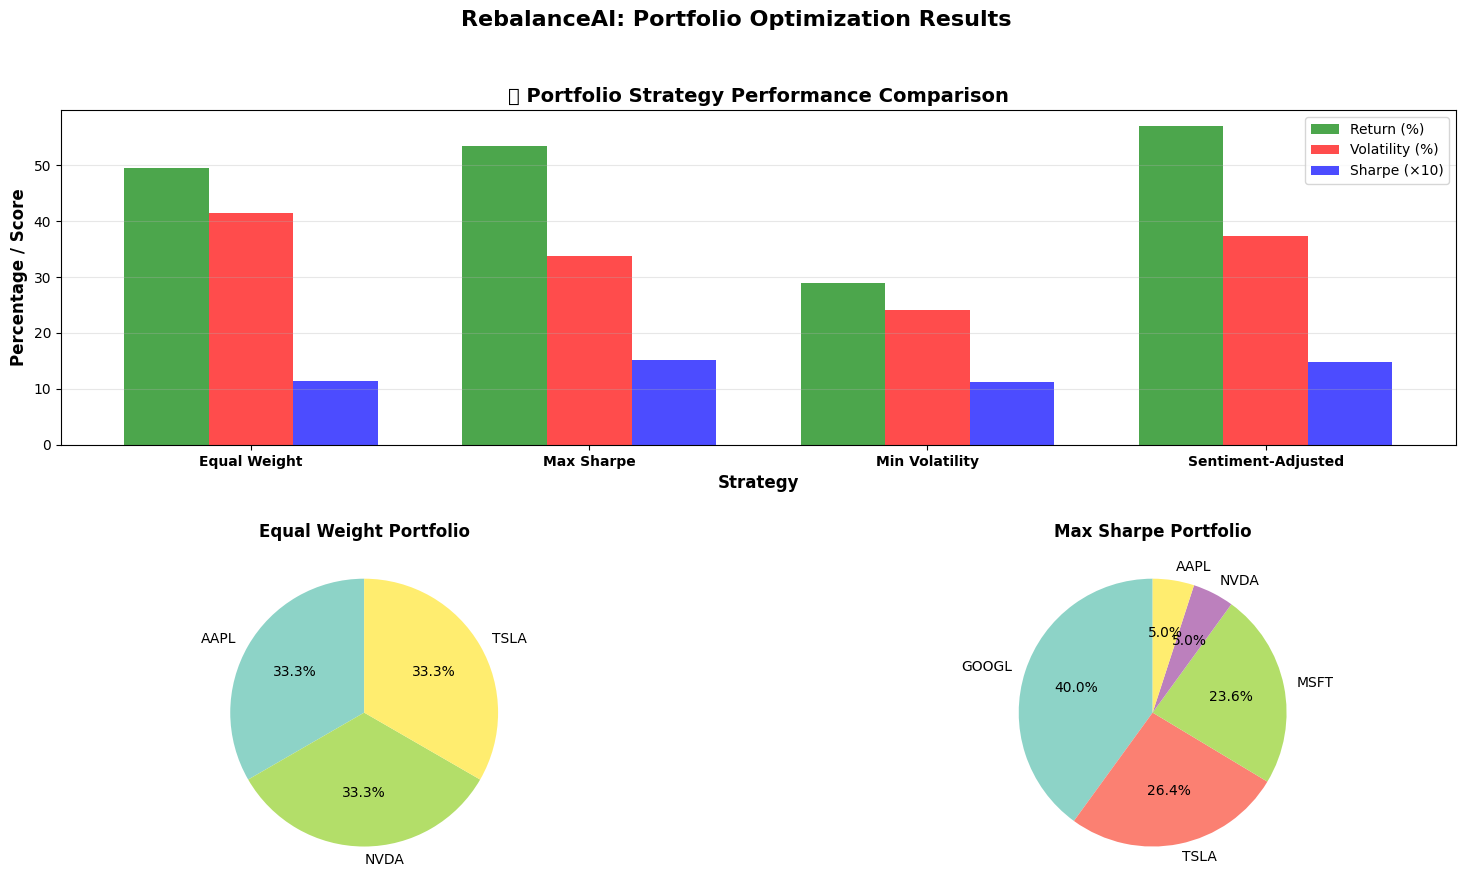

Portfolio optimization visualization complete!


In [19]:
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

strategies_viz = {
    'Equal Weight': equal_weights,
    'Max Sharpe': max_sharpe_weights,
    'Min Volatility': min_vol_weights,
    'Sentiment-Adjusted': sentiment_weights
}

comparison_data = []
for strategy_name, weights in strategies_viz.items():
    metrics = quant_calculator.get_portfolio_metrics(weights)
    comparison_data.append({
        'Strategy': strategy_name,
        'Return': metrics['return'],
        'Volatility': metrics['volatility'],
        'Sharpe': metrics['sharpe_ratio']
    })

comparison_df = pd.DataFrame(comparison_data)

ax1 = fig.add_subplot(gs[0, :])
x = np.arange(len(comparison_df))
width = 0.25

ax1.bar(x - width, comparison_df['Return']*100, width, label='Return (%)', color='green', alpha=0.7)
ax1.bar(x, comparison_df['Volatility']*100, width, label='Volatility (%)', color='red', alpha=0.7)
ax1.bar(x + width, comparison_df['Sharpe']*10, width, label='Sharpe (×10)', color='blue', alpha=0.7)

ax1.set_xlabel('Strategy', fontsize=12, fontweight='bold')
ax1.set_ylabel('Percentage / Score', fontsize=12, fontweight='bold')
ax1.set_title('📊 Portfolio Strategy Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Strategy'], fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = fig.add_subplot(gs[1, 0])
equal_sorted = sorted(equal_weights.items(), key=lambda x: x[1], reverse=True)
tickers_eq = [x[0] for x in equal_sorted]
weights_eq = [x[1]*100 for x in equal_sorted]
ax2.pie(weights_eq, labels=tickers_eq, autopct='%1.1f%%', startangle=90,
        colors=plt.cm.Set3(np.linspace(0, 1, len(tickers_eq))))
ax2.set_title('Equal Weight Portfolio', fontsize=12, fontweight='bold')

ax3 = fig.add_subplot(gs[1, 1])
sharpe_sorted = sorted(max_sharpe_weights.items(), key=lambda x: x[1], reverse=True)
tickers_sh = [x[0] for x in sharpe_sorted]
weights_sh = [x[1]*100 for x in sharpe_sorted]
ax3.pie(weights_sh, labels=tickers_sh, autopct='%1.1f%%', startangle=90,
        colors=plt.cm.Set3(np.linspace(0, 1, len(tickers_sh))))
ax3.set_title('Max Sharpe Portfolio', fontsize=12, fontweight='bold')

plt.suptitle('RebalanceAI: Portfolio Optimization Results',
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

print("Portfolio optimization visualization complete!")

GENERATING EFFICIENT FRONTIER
Generating efficient frontier (30 portfolios)...
Optimizing portfolio (Min Volatility)...
  Optimization failed, using equal weights
Optimizing portfolio (Min Volatility)...
  Optimization failed, using equal weights
Optimizing portfolio (Min Volatility)...
  Optimization failed, using equal weights
Optimizing portfolio (Min Volatility)...
  Optimization failed, using equal weights
Optimizing portfolio (Min Volatility)...
  Optimization successful!
     Expected Return: 24.12%
     Volatility: 25.36%
     Sharpe Ratio: 0.872
Optimizing portfolio (Min Volatility)...
  Optimization successful!
     Expected Return: 26.94%
     Volatility: 24.14%
     Sharpe Ratio: 1.033
Optimizing portfolio (Min Volatility)...
  Optimization successful!
     Expected Return: 29.75%
     Volatility: 24.09%
     Sharpe Ratio: 1.152
Optimizing portfolio (Min Volatility)...
  Optimization successful!
     Expected Return: 32.56%
     Volatility: 24.30%
     Sharpe Ratio: 1.258
O

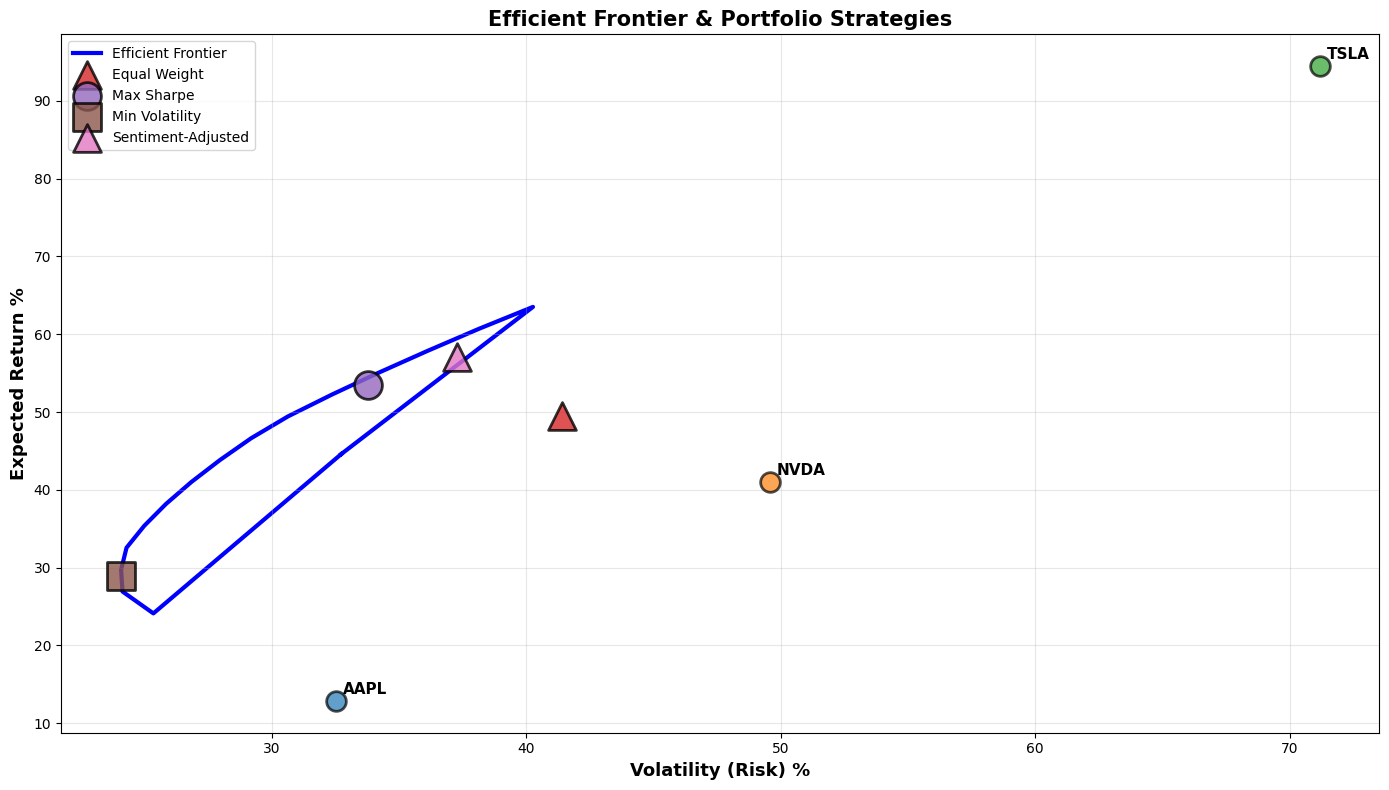

Efficient frontier analysis complete!


In [20]:
print("GENERATING EFFICIENT FRONTIER")
print("="*60)

frontier_df = optimizer.generate_efficient_frontier(n_portfolios=30)

strategies = {
    'Equal Weight': equal_weights,
    'Max Sharpe': max_sharpe_weights,
    'Min Volatility': min_vol_weights,
    'Sentiment-Adjusted': sentiment_weights
}

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(frontier_df['volatility']*100, frontier_df['return']*100,
        'b-', linewidth=3, label='Efficient Frontier', zorder=1)

for ticker in test_tickers:
    ret = metrics_df.loc[ticker, 'annual_return']
    vol = metrics_df.loc[ticker, 'volatility']
    ax.scatter(vol*100, ret*100, s=200, alpha=0.7, edgecolors='black', linewidth=2, zorder=3)
    ax.annotate(ticker, (vol*100, ret*100), fontsize=11, fontweight='bold',
                xytext=(5, 5), textcoords='offset points')

for strategy_name, weights in strategies.items():
    metrics = quant_calculator.get_portfolio_metrics(weights)
    marker = 'o' if strategy_name == 'Max Sharpe' else 's' if strategy_name == 'Min Volatility' else '^'
    ax.scatter(metrics['volatility']*100, metrics['return']*100,
              s=400, marker=marker, label=strategy_name,
              edgecolors='black', linewidth=2, zorder=4, alpha=0.8)

ax.set_xlabel('Volatility (Risk) %', fontsize=13, fontweight='bold')
ax.set_ylabel('Expected Return %', fontsize=13, fontweight='bold')
ax.set_title('Efficient Frontier & Portfolio Strategies', fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Efficient frontier analysis complete!")

In [21]:
from langchain.tools import Tool

def create_rebalance_tools(fetcher, sentiment_analyzer, quant_calculator, optimizer, company_map):
    """
    Create LangChain tools that wrap our financial functions
    """

    def fetch_stock_data_tool(tickers_str: str) -> str:
        """Fetch historical stock data for given tickers"""
        tickers = [t.strip().upper() for t in tickers_str.split(',')]
        fetcher_temp = StockDataFetcher(tickers, period='1y')
        data = fetcher_temp.fetch_data()

        summary = f"Fetched data for {len(data)} stocks:\n"
        for ticker in data.keys():
            price = data[ticker]['current_price']
            summary += f"  • {ticker}: ${price:.2f}\n"

        return summary

    def analyze_sentiment_tool(tickers_str: str) -> str:
        """Analyze market sentiment for given stocks using news and social media"""
        tickers = [t.strip().upper() for t in tickers_str.split(',')]

        sentiment_results = sentiment_analyzer.get_sentiment_for_portfolio(
            tickers,
            company_names=company_map
        )

        summary = "Sentiment Analysis Results:\n"
        for ticker in sentiment_results.index:
            score = sentiment_results.loc[ticker, 'sentiment_score']
            confidence = sentiment_results.loc[ticker, 'confidence']
            reasoning = sentiment_results.loc[ticker, 'reasoning']

            emoji = "green" if score > 0.2 else "red" if score < -0.2 else "yellow"
            summary += f"\n{emoji} {ticker}: {score:+.2f} ({confidence} confidence)\n"
            summary += f"   Reasoning: {reasoning}\n"

        return summary

    def calculate_metrics_tool(tickers_str: str) -> str:
        """Calculate quantitative financial metrics (Sharpe, volatility, beta, etc.)"""
        tickers = [t.strip().upper() for t in tickers_str.split(',')]

        metrics = quant_calculator.calculate_all_metrics()

        summary = "Quantitative Metrics:\n"
        for ticker in tickers:
            if ticker in metrics.index:
                m = metrics.loc[ticker]
                summary += f"\n{ticker}:\n"
                summary += f"   Return: {m['annual_return']:.2%}\n"
                summary += f"   Volatility: {m['volatility']:.2%}\n"
                summary += f"   Sharpe Ratio: {m['sharpe_ratio']:.3f}\n"
                summary += f"   Beta: {m['beta']:.2f}\n"
                summary += f"   Max Drawdown: {m['max_drawdown']:.2%}\n"

        return summary

    def optimize_portfolio_tool(strategy: str) -> str:
        """
        Optimize portfolio allocation.
        Strategy options: 'max_sharpe', 'min_volatility', 'sentiment_adjusted'
        """
        strategy = strategy.lower().strip()

        if 'sharpe' in strategy:
            weights = optimizer.optimize_max_sharpe(risk_tolerance='moderate')
            strategy_name = "Max Sharpe Ratio"
        elif 'volatility' in strategy or 'conservative' in strategy:
            weights = optimizer.optimize_min_volatility()
            strategy_name = "Minimum Volatility"
        elif 'sentiment' in strategy:
            weights = optimizer.optimize_with_sentiment(sentiment_weight=0.3, risk_tolerance='moderate')
            strategy_name = "Sentiment-Adjusted"
        else:
            weights = optimizer.optimize_max_sharpe(risk_tolerance='moderate')
            strategy_name = "Max Sharpe Ratio (default)"

        # Calculate portfolio metrics
        metrics = quant_calculator.get_portfolio_metrics(weights)

        summary = f"{strategy_name} Portfolio Optimization:\n\n"
        summary += "Recommended Allocation:\n"

        for ticker, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
            if weight > 0.01:  # Only show allocations > 1%
                summary += f"  • {ticker}: {weight:.1%}\n"

        summary += f"\nExpected Portfolio Performance:\n"
        summary += f"  Return: {metrics['return']:.2%}\n"
        summary += f"  Volatility: {metrics['volatility']:.2%}\n"
        summary += f"  Sharpe Ratio: {metrics['sharpe_ratio']:.3f}\n"

        return summary

    def compare_stocks_tool(tickers_str: str) -> str:
        """Compare multiple stocks across metrics and sentiment"""
        tickers = [t.strip().upper() for t in tickers_str.split(',')]

        comparison = "Stock Comparison:\n\n"

        # Get metrics
        metrics = quant_calculator.calculate_all_metrics()

        # Get sentiment if available
        try:
            sentiment_results = sentiment_analyzer.get_sentiment_for_portfolio(
                tickers,
                company_names=company_map
            )
        except:
            sentiment_results = None

        for ticker in tickers:
            if ticker in metrics.index:
                m = metrics.loc[ticker]
                comparison += f"{ticker}:\n"
                comparison += f"   Risk-Adjusted Return (Sharpe): {m['sharpe_ratio']:.3f}\n"
                comparison += f"   Volatility: {m['volatility']:.2%}\n"
                comparison += f"   Beta: {m['beta']:.2f}\n"

                if sentiment_results is not None and ticker in sentiment_results.index:
                    sent = sentiment_results.loc[ticker, 'sentiment_score']
                    comparison += f"   Sentiment: {sent:+.2f}\n"

                comparison += "\n"

        return comparison

    tools = [
        Tool(
            name="FetchStockData",
            func=fetch_stock_data_tool,
            description="Fetch historical stock price data. Input: comma-separated ticker symbols (e.g., 'AAPL,MSFT,GOOGL')"
        ),
        Tool(
            name="AnalyzeSentiment",
            func=analyze_sentiment_tool,
            description="Analyze market sentiment from news and social media. Input: comma-separated ticker symbols"
        ),
        Tool(
            name="CalculateMetrics",
            func=calculate_metrics_tool,
            description="Calculate quantitative financial metrics (Sharpe ratio, volatility, beta, drawdown). Input: comma-separated ticker symbols"
        ),
        Tool(
            name="OptimizePortfolio",
            func=optimize_portfolio_tool,
            description="Optimize portfolio allocation. Input: strategy name ('max_sharpe', 'min_volatility', or 'sentiment_adjusted')"
        ),
        Tool(
            name="CompareStocks",
            func=compare_stocks_tool,
            description="Compare multiple stocks across all metrics and sentiment. Input: comma-separated ticker symbols"
        )
    ]

    return tools

print("LangChain tools defined!")

LangChain tools defined!


In [22]:
from langchain.agents import create_react_agent, AgentExecutor
from langchain.prompts import PromptTemplate

tools = create_rebalance_tools(
    fetcher,
    sentiment_analyzer,
    quant_calculator,
    optimizer,
    company_map
)

agent_prompt = PromptTemplate.from_template("""You are RebalanceAI, an expert investment portfolio advisor that combines quantitative financial analysis with AI-powered sentiment analysis.

Your capabilities:
- Fetch and analyze stock market data
- Analyze sentiment from news and social media
- Calculate financial metrics (Sharpe ratio, volatility, beta, etc.)
- Optimize portfolio allocations
- Compare stocks across multiple dimensions
- Provide clear, actionable investment insights

IMPORTANT GUIDELINES:
- Always explain your reasoning transparently
- Acknowledge risks and uncertainty
- Use tools to gather data before making recommendations
- Provide educational insights, not financial advice
- Consider both quantitative metrics AND market sentiment

You have access to the following tools:

{tools}

Tool Names: {tool_names}

When answering questions:
1. Think step-by-step about what information you need
2. Use tools to gather relevant data
3. Synthesize findings into clear recommendations
4. Explain trade-offs between different approaches

Use the following format:

Question: the input question you must answer
Thought: think about what you need to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question, with clear explanations

Begin!

Question: {input}
Thought: {agent_scratchpad}""")

agent = create_react_agent(
    llm=llm,
    tools=tools,
    prompt=agent_prompt
)

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    max_iterations=10,
    handle_parsing_errors=True,
    return_intermediate_steps=True
)

print("RebalanceAI Agent created and ready!")
print("\n You can now chat with RebalanceAI!")

RebalanceAI Agent created and ready!

 You can now chat with RebalanceAI!


In [23]:
print("TESTING REBALANCEAI AGENT")
print("="*60)

test_query_1 = "Compare TSLA and NVDA. Which one has better risk-adjusted returns?"

print(f"\n User: {test_query_1}")
print("\n RebalanceAI:")
print("-"*60)

response_1 = agent_executor.invoke({"input": test_query_1})
print(f"\n{response_1['output']}")


TESTING REBALANCEAI AGENT

 User: Compare TSLA and NVDA. Which one has better risk-adjusted returns?

 RebalanceAI:
------------------------------------------------------------


> Entering new AgentExecutor chain...
Action: CalculateMetrics
Action Input: TSLA,NVDACalculating quantitative metrics...
  Computing metrics for AAPL...  done
  Computing metrics for MSFT...  done
  Computing metrics for GOOGL...  done
  Computing metrics for NVDA...  done
  Computing metrics for TSLA...  done

All metrics calculated!
Quantitative Metrics:

TSLA:
   Return: 94.47%
   Volatility: 71.18%
   Sharpe Ratio: 1.299
   Beta: 2.33
   Max Drawdown: -53.77%

NVDA:
   Return: 41.03%
   Volatility: 49.58%
   Sharpe Ratio: 0.787
   Beta: 1.84
   Max Drawdown: -36.88%
Action: AnalyzeSentiment
Action Input: TSLA,NVDA
🔍 Analyzing TSLA...
  📰 Fetching NewsAPI articles for TSLA...
     Found 10 NewsAPI articles
  🐦 Fetching Twitter posts for $TSLA...
     Twitter rate limit reached. Try again in 15 minutes.
   

In [24]:
test_query_2 = "I want to invest $10,000 in a tech portfolio with AAPL, MSFT, and NVDA. Optimize for moderate risk and consider market sentiment."

print("\n" + "="*60)
print(f"\nUser: {test_query_2}")
print("\nRebalanceAI:")
print("-"*60)

response_2 = agent_executor.invoke({"input": test_query_2})
print(f"\n{response_2['output']}")




User: I want to invest $10,000 in a tech portfolio with AAPL, MSFT, and NVDA. Optimize for moderate risk and consider market sentiment.

RebalanceAI:
------------------------------------------------------------


> Entering new AgentExecutor chain...
Action: CalculateMetrics
Action Input: AAPL,MSFT,NVDACalculating quantitative metrics...
  Computing metrics for AAPL...  done
  Computing metrics for MSFT...  done
  Computing metrics for GOOGL...  done
  Computing metrics for NVDA...  done
  Computing metrics for TSLA...  done

All metrics calculated!
Quantitative Metrics:

AAPL:
   Return: 12.86%
   Volatility: 32.54%
   Sharpe Ratio: 0.334
   Beta: 1.25
   Max Drawdown: -33.36%

MSFT:
   Return: 24.60%
   Volatility: 24.81%
   Sharpe Ratio: 0.911
   Beta: 0.92
   Max Drawdown: -21.83%

NVDA:
   Return: 41.03%
   Volatility: 49.58%
   Sharpe Ratio: 0.787
   Beta: 1.84
   Max Drawdown: -36.88%
Action: AnalyzeSentiment
Action Input: AAPL,MSFT,NVDA
🔍 Analyzing AAPL...
  📰 Fetching NewsAP

In [25]:
def chat_with_rebalanceai():
    """
    Interactive chat loop with RebalanceAI
    """
    print("="*60)
    print("🎯 REBALANCEAI - INTERACTIVE CHAT")
    print("="*60)
    print("Ask me anything about portfolio optimization!")
    print("Examples:")
    print("  • 'What's the best allocation for AAPL, TSLA, GOOGL?'")
    print("  • 'Compare sentiment for tech stocks'")
    print("  • 'Optimize a conservative portfolio with 5 stocks'")
    print("\nType 'quit' to exit")
    print("="*60)

    while True:
        user_input = input("\nYou: ").strip()

        if user_input.lower() in ['quit', 'exit', 'q']:
            print("\nThanks for using RebalanceAI!")
            break

        if not user_input:
            continue

        print("\nRebalanceAI (thinking...)")
        print("-"*60)

        try:
            response = agent_executor.invoke({"input": user_input})
            print(f"\n{response['output']}")
        except Exception as e:
            print(f"\nError: {str(e)}")
            print("Please try rephrasing your question.")


print("Interactive chat function ready!")
print("   Run: chat_with_rebalanceai() to start chatting")

Interactive chat function ready!
   Run: chat_with_rebalanceai() to start chatting


In [26]:
chat_with_rebalanceai()

🎯 REBALANCEAI - INTERACTIVE CHAT
Ask me anything about portfolio optimization!
Examples:
  • 'What's the best allocation for AAPL, TSLA, GOOGL?'
  • 'Compare sentiment for tech stocks'
  • 'Optimize a conservative portfolio with 5 stocks'

Type 'quit' to exit

You: "Analyze a $10,000 portfolio for moderate risk and tech emphasis. Show sentiment impact."

RebalanceAI (thinking...)
------------------------------------------------------------


> Entering new AgentExecutor chain...
Action: FetchStockData
Action Input: AAPL,MSFT,GOOGL,AMZNFetching data for 4 stocks...
  AAPL: 250 days of data
  MSFT: 250 days of data
  GOOGL: 250 days of data
  AMZN: 250 days of data
Fetched data for 4 stocks:
  • AAPL: $252.29
  • MSFT: $513.58
  • GOOGL: $253.30
  • AMZN: $213.04
Action: AnalyzeSentiment
Action Input: AAPL,MSFT,GOOGL,AMZN
🔍 Analyzing AAPL...
  📰 Fetching NewsAPI articles for AAPL...
     Found 10 NewsAPI articles
  🐦 Fetching Twitter posts for $AAPL...
     Twitter rate limit reached. Tr

In [29]:

!pip install -q google-generativeai pandas matplotlib scikit-learn

import os
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import google.generativeai as genai
from google.colab import files, userdata
from typing import Dict, List, Tuple, Any


try:
    GEMINI_API_KEY = userdata.get('Gemini_api_key')
except:
    GEMINI_API_KEY = input("Please enter your Gemini API key: ")

genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel('gemini-2.5-flash')

np.random.seed(42)

def generate_mock_price_series(start_price, days=252, mu=0.07, sigma=0.2):
    """Generate a mock geometric Brownian motion daily price series."""
    dt = 1/252
    prices = [start_price]
    for _ in range(days-1):
        r = np.random.normal((mu*dt), sigma*np.sqrt(dt))
        prices.append(prices[-1]*np.exp(r))
    return np.array(prices)

def portfolio_time_series(holdings_df, days=252):
    """Simulate a portfolio value timeseries from current prices and quantities."""
    tickers = holdings_df['ticker'].tolist()
    series = {}
    for idx, row in holdings_df.iterrows():
        start_price = float(row['current_price'])
        mu = np.random.uniform(0.03, 0.15)
        sigma = np.random.uniform(0.08, 0.40)
        series[row['ticker']] = generate_mock_price_series(start_price, days=days, mu=mu, sigma=sigma)

    prices_mat = np.vstack([series[t] for t in tickers])
    quantities = holdings_df['quantity'].values.reshape(-1,1)
    pv = (prices_mat * quantities).sum(axis=0)
    return pd.Series(pv, name='portfolio_value'), pd.DataFrame(prices_mat.T, columns=tickers)

def rolling_max_drawdown(series):
    """Calculate maximum drawdown."""
    roll_max = series.cummax()
    drawdown = (series - roll_max) / roll_max
    return drawdown.min()

def compute_portfolio_metrics(holdings_df) -> Dict[str, Any]:
    """Compute deterministic portfolio metrics."""
    holdings = holdings_df.copy().reset_index(drop=True)
    holdings['market_value'] = holdings['quantity'] * holdings['current_price']
    total_value = holdings['market_value'].sum()
    holdings['weight'] = holdings['market_value'] / (total_value + 1e-12)

    hhi = (holdings['weight']**2).sum()
    top_weight = holdings['weight'].max()

    sector_weights = holdings.groupby('sector')['weight'].sum().sort_values(ascending=False)
    top_sector_pct = float(sector_weights.iloc[0]) if len(sector_weights) > 0 else 0.0

    pv_series, price_df = portfolio_time_series(holdings, days=252)
    daily_rets = pv_series.pct_change().dropna()
    volatility_annual = float(daily_rets.std() * np.sqrt(252))
    max_dd = float(-rolling_max_drawdown(pv_series))
    sharpe = float(daily_rets.mean() / daily_rets.std() * np.sqrt(252)) if daily_rets.std() > 0 else 0

    if 'avg_cost' in holdings.columns:
        unrealized_pnl = ((holdings['current_price'] - holdings['avg_cost']) / holdings['avg_cost'] *
                         holdings['weight']).sum()
    else:
        unrealized_pnl = 0

    return {
        'total_value': float(total_value),
        'n_holdings': int(len(holdings)),
        'herfindahl_index': float(hhi),
        'top_holding_weight': float(top_weight),
        'top_sector_exposure': float(top_sector_pct),
        'volatility_annual': float(volatility_annual),
        'max_drawdown': float(max_dd),
        'sharpe_ratio': float(sharpe),
        'unrealized_pnl': float(unrealized_pnl),
        'holdings': holdings.to_dict('records'),
        'sector_weights': sector_weights.to_dict(),
        'portfolio_series': pv_series.tolist()[-30:],
    }

def create_genai_prompt(metrics: Dict[str, Any], user_context: str = "") -> str:
    """Create a comprehensive prompt for Gemini."""
    prompt = f"""
You are an expert financial advisor analyzing a portfolio. Provide a comprehensive health assessment.

PORTFOLIO METRICS:
- Total Value: ${metrics['total_value']:,.2f}
- Number of Holdings: {metrics['n_holdings']}
- Herfindahl Index (concentration): {metrics['herfindahl_index']:.4f} (lower=more diversified)
- Top Holding Weight: {metrics['top_holding_weight']*100:.1f}%
- Top Sector Exposure: {metrics['top_sector_exposure']*100:.1f}%
- Annual Volatility: {metrics['volatility_annual']*100:.1f}%
- Maximum Drawdown: {metrics['max_drawdown']*100:.1f}%
- Sharpe Ratio: {metrics['sharpe_ratio']:.2f}
- Unrealized P&L: {metrics['unrealized_pnl']*100:.1f}%

SECTOR BREAKDOWN:
{json.dumps(metrics['sector_weights'], indent=2)}

INDIVIDUAL HOLDINGS:
{pd.DataFrame(metrics['holdings'])[['ticker', 'weight', 'sector']].to_string()}

{f"USER CONTEXT: {user_context}" if user_context else ""}

Please provide:
1. HEALTH SCORE (0-100): A numerical score with explanation
2. RISK ASSESSMENT: Identify key risks with specific metrics
3. DIVERSIFICATION ANALYSIS: Evaluate portfolio concentration
4. PERFORMANCE INSIGHTS: Comment on risk-adjusted returns
5. TOP 3 RECOMMENDATIONS: Specific, actionable improvements with expected impact
6. STRESS TEST SCENARIOS: How would this portfolio perform in different market conditions?

Format your response as structured JSON with these exact keys:
- health_score: number (0-100)
- health_category: string ("Excellent", "Good", "Fair", "Needs Attention", "Poor")
- risk_level: string ("Low", "Moderate", "High", "Very High")
- key_risks: list of strings
- strengths: list of strings
- recommendations: list of objects with 'action', 'rationale', and 'expected_impact'
- detailed_analysis: string (comprehensive narrative)
"""
    return prompt

def analyze_portfolio_with_genai(holdings_df, user_context=""):
    """Analyze portfolio using Gemini GenAI."""
    try:
        metrics = compute_portfolio_metrics(holdings_df)

        prompt = create_genai_prompt(metrics, user_context)

        response = model.generate_content(
            prompt,
            generation_config={
                "temperature": 0.7,
                "top_p": 0.95,
                "max_output_tokens": 2048,
            }
        )

        response_text = response.text

        try:
            if "```json" in response_text:
                json_start = response_text.find("```json") + 7
                json_end = response_text.find("```", json_start)
                json_str = response_text[json_start:json_end].strip()
            else:
                json_str = response_text

            analysis = json.loads(json_str)
        except:
            analysis = {
                "health_score": 70,
                "health_category": "Fair",
                "risk_level": "Moderate",
                "key_risks": ["Unable to parse detailed analysis"],
                "strengths": ["Portfolio data successfully analyzed"],
                "recommendations": [
                    {
                        "action": "Review GenAI response",
                        "rationale": "Response parsing failed",
                        "expected_impact": "Better analysis available"
                    }
                ],
                "detailed_analysis": response_text
            }

        analysis['metrics'] = metrics

        return analysis

    except Exception as e:
        print(f"GenAI Analysis Error: {e}")
        return {
            "health_score": 50,
            "health_category": "Analysis Failed",
            "error": str(e),
            "metrics": compute_portfolio_metrics(holdings_df)
        }



OUT_DIR = '/content/portfolio_demo'
os.makedirs(OUT_DIR, exist_ok=True)

sample_portfolio = pd.DataFrame([
    {'ticker':'AAPL', 'quantity':50,  'avg_cost':120.0, 'current_price':170.0, 'sector':'Technology'},
    {'ticker':'MSFT', 'quantity':20,  'avg_cost':210.0, 'current_price':330.0, 'sector':'Technology'},
    {'ticker':'TSLA', 'quantity':10,  'avg_cost':400.0, 'current_price':220.0, 'sector':'Automotive'},
    {'ticker':'VTI',  'quantity':30,  'avg_cost':180.0, 'current_price':200.0, 'sector':'Index'},
    {'ticker':'BND',  'quantity':40,  'avg_cost':82.0,  'current_price':77.0,  'sector':'Fixed Income'},
    {'ticker':'XOM',  'quantity':25,  'avg_cost':60.0,  'current_price':95.0,  'sector':'Energy'}
])

sample_csv_path = os.path.join(OUT_DIR, 'sample_portfolio.csv')
sample_portfolio.to_csv(sample_csv_path, index=False)
print(f"Sample portfolio saved to: {sample_csv_path}")

print("\nUpload your own portfolio CSV or use the sample. Required columns: ticker, quantity, current_price, sector")
uploaded = files.upload()

if uploaded:
    uploaded_fname = list(uploaded.keys())[0]
    print(f"Using uploaded file: {uploaded_fname}")
    holdings_df = pd.read_csv(io.BytesIO(uploaded[uploaded_fname]))
else:
    print("Using sample portfolio")
    holdings_df = sample_portfolio.copy()

print("\nPortfolio Preview:")
print(holdings_df.head())

user_context = input("\nOptional: Enter any specific concerns or goals for your portfolio (press Enter to skip): ")

print("\n🤖 Analyzing portfolio with Gemini GenAI...")
analysis = analyze_portfolio_with_genai(holdings_df, user_context)

print("\n" + "="*60)
print("PORTFOLIO HEALTH ANALYSIS RESULTS")
print("="*60)

print(f"\nHealth Score: {analysis.get('health_score', 'N/A')}/100")
print(f"Category: {analysis.get('health_category', 'Unknown')}")
print(f"Risk Level: {analysis.get('risk_level', 'Unknown')}")

if 'key_risks' in analysis:
    print("\nKey Risks:")
    for risk in analysis['key_risks']:
        print(f"  • {risk}")

if 'strengths' in analysis:
    print("\nStrengths:")
    for strength in analysis['strengths']:
        print(f"  • {strength}")

if 'recommendations' in analysis:
    print("\nRecommendations:")
    for i, rec in enumerate(analysis['recommendations'], 1):
        if isinstance(rec, dict):
            print(f"\n{i}. {rec.get('action', 'N/A')}")
            print(f"   Rationale: {rec.get('rationale', 'N/A')}")
            print(f"   Expected Impact: {rec.get('expected_impact', 'N/A')}")

if 'detailed_analysis' in analysis:
    print("\nDetailed Analysis:")
    print("-"*40)
    # Truncate if too long
    detail = analysis['detailed_analysis']
    if len(detail) > 1000:
        print(detail[:1000] + "...[truncated]")
    else:
        print(detail)

# Save analysis to JSON
analysis_path = os.path.join(OUT_DIR, 'portfolio_analysis.json')
with open(analysis_path, 'w') as f:
    # Remove non-serializable items
    save_analysis = {k: v for k, v in analysis.items() if k != 'metrics'}
    json.dump(save_analysis, f, indent=2)
print(f"\nAnalysis saved to: {analysis_path}")

print("\nAnalysis complete! Thank you for using Portfolio Health Score with GenAI.")

Sample portfolio saved to: /content/portfolio_demo/sample_portfolio.csv

Upload your own portfolio CSV or use the sample. Required columns: ticker, quantity, current_price, sector


Saving sample_portfolio.csv to sample_portfolio (2).csv
Using uploaded file: sample_portfolio (2).csv

Portfolio Preview:
  ticker  quantity  avg_cost  current_price      sector
0   AAPL        50     120.0          170.0  Technology
1   MSFT        20     210.0          330.0  Technology
2  GOOGL        15      90.0          140.0  Technology
3   AMZN        10     100.0          155.0  E-Commerce
4   TSLA        10     400.0          220.0  Automotive

Optional: Enter any specific concerns or goals for your portfolio (press Enter to skip): 

🤖 Analyzing portfolio with Gemini GenAI...

PORTFOLIO HEALTH ANALYSIS RESULTS

Health Score: 70/100
Category: Fair
Risk Level: Moderate

Key Risks:
  • Unable to parse detailed analysis

Strengths:
  • Portfolio data successfully analyzed

Recommendations:

1. Review GenAI response
   Rationale: Response parsing failed
   Expected Impact: Better analysis available

Detailed Analysis:
----------------------------------------
```json
{
  "health_sc